In [ ]:
# A notebook implementation of a script created to test 'ERT with priors' on data from Op 't Hof

# Demonstrating/applying prior ground truth information to ERT
## Example with data from Op 't Hof, Zeeland

This is a notebook version of a script previously set up and tested for the inversion of ERT roll-along data from Op 't Hof, Zeeland, recorded in spring 2024, to integrate some layer information and water EC data. The *a priori* data for this location is good, but more detail would be useful if the context were more complex. In this case, however, the subsurface is fairly simple.

With this notebook, a possible processing sequence is introduced, starting with 'unconstrained' inversion, where no prior information is introduced. With the information from the unconstrained inversion, we can then integrate other information we (may) have about the subsurface, such as layer boundaries and/or resistivity information. The most complex constraint method in pyGIMLi (as of September 2024) is apply geostatistical regularisation to integrate a vertical resistivity-depth profile (e.g. from borehole measurements).

There is more background on regularisation (quite theoretical) on the pyGIMLi website at [Regularization - concepts explained](https://www.pygimli.org/_tutorials_auto/3_inversion/plot_5_Regularization.html) and [Geostatistical regularization](https://www.pygimli.org/_tutorials_auto/3_inversion/plot_6-geostatConstraints.html) along with an example using more complex *a priori* data at [Incorporating prior data into ERT inversion](https://www.pygimli.org/_examples_auto/6_inversion/plot_5_ert_with_priors.html).




The first steps are to load pyGIMLi into the Colab space, then import the necessary packages/modules, and link to the source data folder.

In [ ]:
# Install pyGIMLi and dependencies to Colab - ** DO NOT RUN LOCALLY **
!pip install pygimli

In [1]:
import pygimli as pg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pygimli.physics import ert
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling, JointModelling
from pygimli.viewer.mpl import draw1DColumn

datafolder = "..\\exampledata\\NL\\"

The sample data used for this example has been converted to the [Unified Data Format](http://resistivity.net/bert/data_format.html) used by the pyBERT and pyGIMLi working group. In the scripts section of the repository is a routine (txt-to-ohm_Terrameter.py) that reformats Terrameter-style txt files to the UDF format. The script \[as of 30/9/2024] makes some assumptions about input format; notes on that are in the script.

Next section loads the ERT data and 'prior' data with ground resistivity values at a test point. The last line outputs the values loaded from the data file.

In [2]:
data = ert.load(datafolder+"2024-03-07 OPTHOF-ROLL_GradientXL_2_edited.ohm") # Load data to container from BERT format
terrain = pg.z(data) # store the terrain information which gets moved to 'y' axis during inversion; all zeroes for this example

prior = pd.read_csv(datafolder+"layers.txt", sep = "\\s+")#, header = 0) # load the table of estimated/measured layers & properties

print(data, data.tokenList()) # print summary of data container - good to check # of sensors, measurements and channels


Data: Sensors: 121 data: 2879, nonzero entries: ['a', 'b', 'err', 'm', 'n', 'r', 'rhoa', 'valid'] SensorIdx: a b m n  Data: err i ip iperr k r rhoa u valid 


Next up, calculate the geometric factors, and from those and the values of 'r' in the observed data, calculate resistivity, $\rho$(a) which we can compare with the instrument-calculated apparent resistivity. This is probably not essential for flat surveys. Where there is a significant variation in elevation along the line, the geometric factors can be calculated with a numeric method (```numerical=True```) which factors in the topography.

This cell displays both the resistivity from the instrument and the resistivity calculated by pyGIMLi as a product of geometric factor and resistance for each point. This was originally a check that revealed an issue in another script, so I've left it in. The discrepancy between the two should be tiny (not visible on these plots).

01/10/24 - 11:15:22 - pyGIMLi - INFO - Cache C:\ProgramData\anaconda3\envs\pg\Lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 1): C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\6408718515063193285


Text(0.5, 0.98, 'Apparent Resistivity calculated by pyGIMLi')

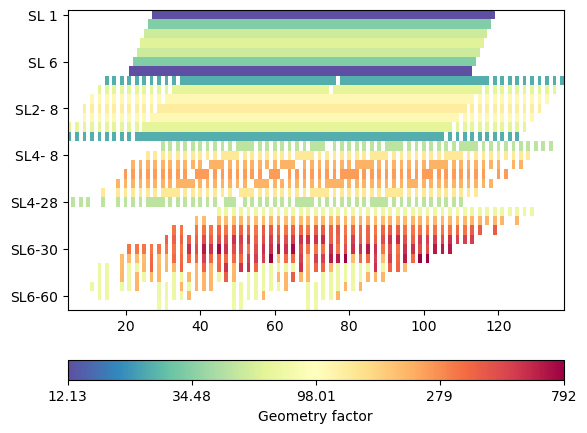

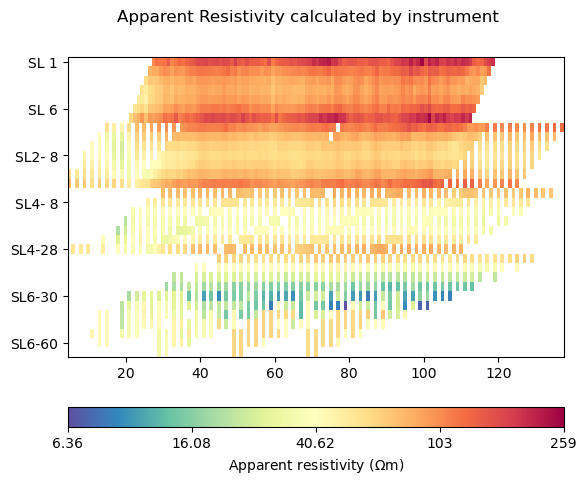

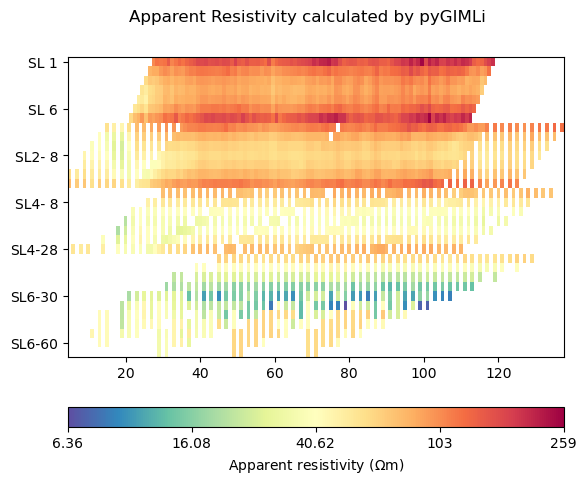

In [3]:
data['k'] = ert.createGeometricFactors(data, numerical=False)
ert.show(data, data['k'], logScale=True, label='Geometry factor')
data['rhoa_calc'] = data['r'] * data['k']

ert.show(data, data['rhoa'])
fig = plt.gcf()
fig.suptitle("Apparent Resistivity calculated by instrument")

ert.show(data, data['rhoa_calc'])
fig = plt.gcf()
fig.suptitle("Apparent Resistivity calculated by pyGIMLi")
# fig.savefig('OptHof_Roll_ObsAppRes.png', dpi=200) # To save an image if you want to (and if that is possible in the Colab platform).

The pyGIMLi inversion code needs an error channel. From this example data, we can use the % variance column from the Terrameter, and have a look at it.

*Comment: I'm sceptical about whether this really represents a valid error scale, as 1.5e-04% seems extremely small, but maybe the recordings really are/were that good. (Matt)*

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x19bab8df750>)

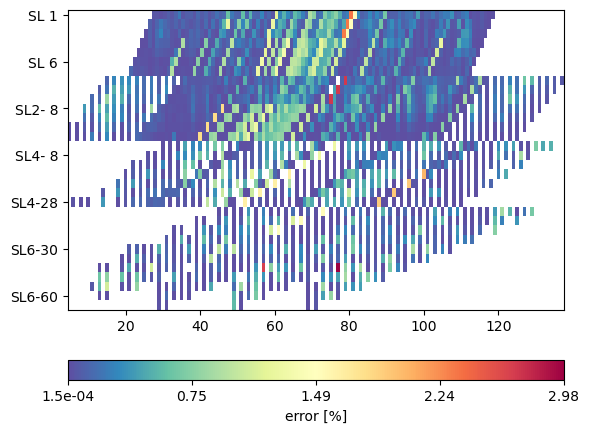

In [4]:
ert.show(data, data['err']*100, label="error [%]", logScale=False)

Next up we're going to define some dictionaries of arguments to carry through the plotting and inversion steps. This way we can make adjustments in one place and keep them consistent later.

In [6]:
# First, inversion keywords...
invkw = dict(data=data, verbose=True, lam=2, zWeight=0.5, robust=True) # lambda is a smoothness constraint, lower zweight emphasises layering

# ...and plotting keywords
plotkw = dict(xlabel="x (m)", ylabel="z (m)", cMap="Spectral_r", cMin=0.2, cMax=200, logScale=True)

Finally, we call up the ERTManager class, and run a standard ERT inversion, with no restrictions or inputs other than the field data and 2 fairly standard parameters for the inversion mesh quality and density.

In [7]:
# call the ERTManager class
mgr = ert.ERTManager(data)
# run the inversion, with some settings for the mesh (and other keywords from cell above)
mgr.invert(quality=34, size=1., **invkw)

01/10/24 - 14:14:51 - pyGIMLi - INFO - Found 2 regions.
01/10/24 - 14:14:51 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
01/10/24 - 14:14:51 - pyGIMLi - INFO - Found 2 regions.
01/10/24 - 14:14:51 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
01/10/24 - 14:14:51 - pyGIMLi - INFO - Creating forward mesh from region infos.
01/10/24 - 14:14:51 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
01/10/24 - 14:14:51 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 6397 Cells: 12192 Boundaries: 9444
01/10/24 - 14:14:52 - pyGIMLi - INFO - Use median(data values)=61.0215
01/10/24 - 14:14:52 - pyGIMLi - INFO - Created startmodel from forward operator: 2463, min/max=61.021500/61.021500
01/10/24 - 14:14:52 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000019BAA6C3C90>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000019BAA6C1EE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000019BA9D6EA40>
min/max (data): 6.36/259
min/max (error): 1.5e-04%/2.98%
min/max (start model): 61.02/61.02
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 323286910.63
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 71732450.65 (dPhi = 77.81%) lam: 2.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 12685431.58 (dPhi = 82.32%) lam: 2.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 218024.03 (dPhi = 98.28%) lam: 2.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 31514.41 

2463 [173.29778995205263,...,14.003349821356336]

Now let's have a look at some plots to examine the result of this inversion. The basic ```showFit``` function is nice to look at, but it's impossible to distinguish anything unless the inversion went seriously wrong. So following that, we can have a look at a misfit calculation taken from the pyGIMLi examples: log(response/data)/error. In the misfit plot, we're mostly interested in any 'stripes' that might indicate a problem series of readings related to particular cable(s) or electrode(s); random scatter is to be expected.

Then finally the inversion result. To display without colour limits, remove the plotkw statement: ```mgr.showResult()```.

Text(0.5, 0.75, 'Inverted Resistivity model, zwt=0.5, lambda=2, robust')

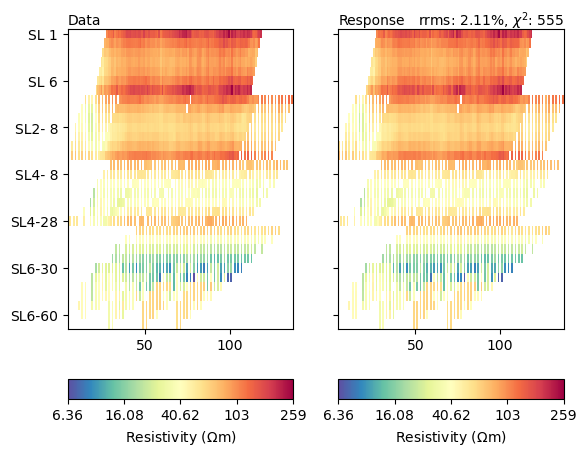

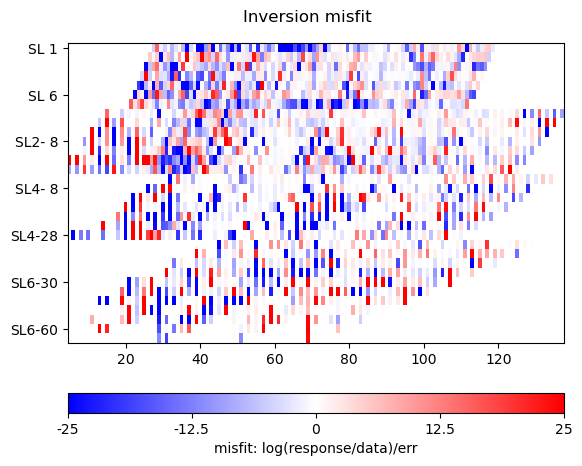

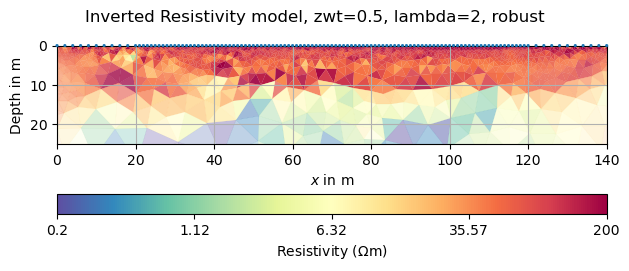

In [23]:
mgr.showFit()

data['misfit'] = pg.log(mgr.inv.response / data["rhoa"]) / data["err"]
pg.show(data, data['misfit'], cMap="bwr", cMin = -25, cMax = 25,
        label='misfit: log(response/data)/err' )
fig = plt.gcf()
fig.suptitle("Inversion misfit", y=0.95)

ax, _ = mgr.showResult(**plotkw)
ax.set_ylim(-25,0)
ax.set_xlim(0,140)
ax.grid()
fig = plt.gcf()
fig.suptitle("Inverted Resistivity model, zwt=0.5, lambda=2, robust", y=0.75)
#fig.savefig('Unconstrained_Inversion.png', dpi=200)

We can see from this inversion that there's basically a 2-layer system: approximately 10-12m with resistivity >50$\Omega$m, over a zone of 1-10$\Omega$m. The system configuration used for this survey did not resolve any further layers.

## Inversion as a layered system
As a layered system, we can try creating an inversion mesh with a boundary layer division similar to the boundary definition approach available in Res2DInv. To do this, we have to create a 'world', add a line, then create the mesh. It is also possible to create the 'world' with a layers definition, but that approach is more restrictive.

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x19bd6190590>)

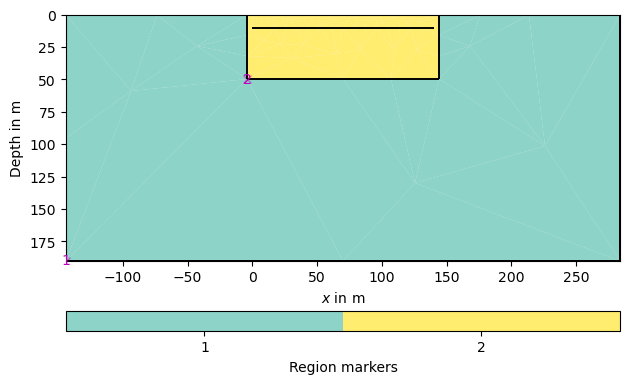

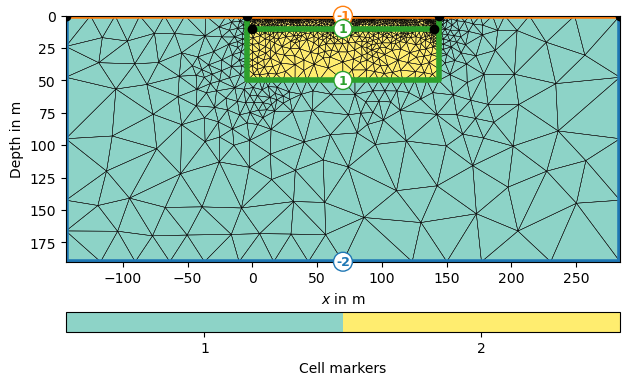

In [21]:
# First, create the world, add a line at 10m depth and have a look at the result
world = mt.createParaMeshPLC(data, paraDepth=50, boundary=1)

line1 = mt.createLine(start=[0, -10], end=[140, -10], marker=3) # marker>0 means it functions as a constraint

world += line1

pg.show(world)

mesh = mt.createMesh(world, quality=34)

pg.show(mesh, markers=True, showMesh=True)

Now we can run a new inversion in this space, with the estimated layer boundary as a constraint.

In [22]:
mgrlayer = ert.ERTManager()
mgrlayer.invert(mesh=mesh, **invkw)

01/10/24 - 15:29:43 - pyGIMLi - INFO - Found 2 regions.
01/10/24 - 15:29:43 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
01/10/24 - 15:29:43 - pyGIMLi - INFO - Creating forward mesh from region infos.
01/10/24 - 15:29:43 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
01/10/24 - 15:29:43 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 7073 Cells: 13568 Boundaries: 10464
01/10/24 - 15:29:43 - pyGIMLi - INFO - Use median(data values)=61.0215
01/10/24 - 15:29:43 - pyGIMLi - INFO - Created startmodel from forward operator: 2873, min/max=61.021500/61.021500
01/10/24 - 15:29:43 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000019BD690B5B0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000019BD512CA40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000019BD37FBF40>
min/max (data): 6.36/259
min/max (error): 1.5e-04%/2.98%
min/max (start model): 61.02/61.02
--------------------------------------------------------------------------------
inv.iter 0 ... chi² = 323286910.63
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 79234059.95 (dPhi = 75.49%) lam: 2.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 17583491.68 (dPhi = 77.81%) lam: 2.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 263530.54 (dPhi = 98.50%) lam: 2.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 34436.45 

2873 [115.93153339711716,...,2.732731253211083]

Now let's have a look at this inversion. with much the same plots as the last time around.

Text(0.5, 0.75, 'Inverted (Layered) Resistivity model, zwt=0.5, lambda=2, robust')

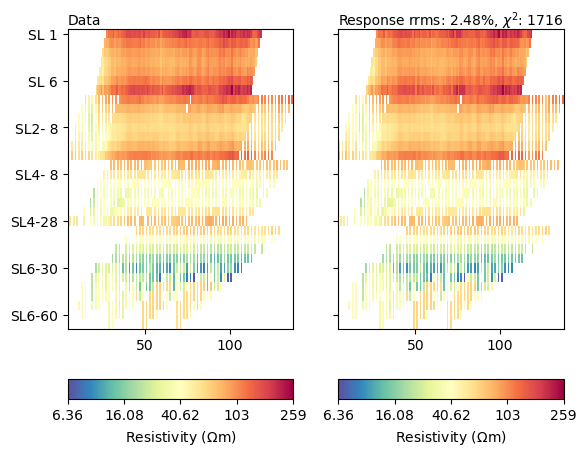

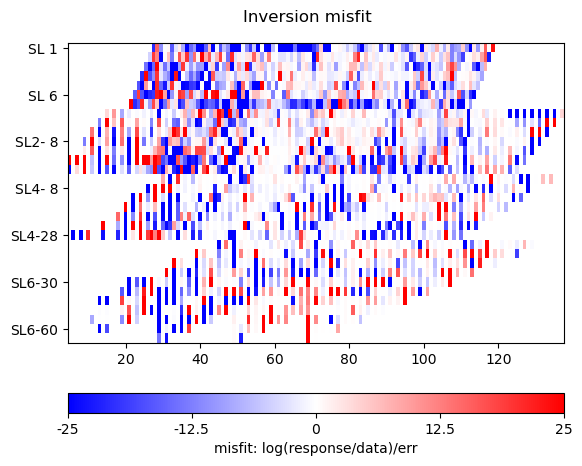

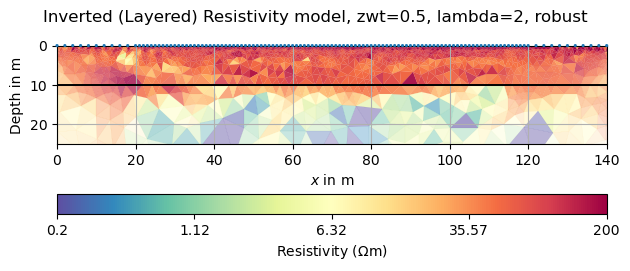

In [24]:
mgrlayer.showFit()

data['misfit'] = pg.log(mgrlayer.inv.response / data["rhoa"]) / data["err"]
pg.show(data, data['misfit'], cMap="bwr", cMin = -25, cMax = 25,
        label='misfit: log(response/data)/err' )
fig = plt.gcf()
fig.suptitle("Inversion misfit", y=0.95)

ax, _ = mgrlayer.showResult(**plotkw)
ax.set_ylim(-25,0)
ax.set_xlim(0,140)
ax.grid()
fig = plt.gcf()
fig.suptitle("Inverted (Layered) Resistivity model, zwt=0.5, lambda=2, robust", y=0.75)
#fig.savefig('Layered_Inversion.png', dpi=200)

Although there is (perhaps) a little more consistency to the resistivity shown in each layer, the impact of adding this layer boundary is not dramatic in this case. There is probably a few different reasons for this result: the resistivity change might be smoother or more irregular than this type of constraint suggests, or the depth set for the boundary might not match the real depth so that the constraint is forcing something that's not right.

## Inversion with *a priori* data
So next we'll try to incorporate some *a priori* data. This is adapted from a much more complex example published by the pyGIMLi group, where the improvements are more dramatic. Nonetheless, we can look at the process using a depth-resistivity column drawn from sample data in documentation for this project, combined with interpretation of the unconstrained inversion.

It would be great to try this on a more complete downhole/CP test with water quality & soil type information with depth.

First, let's have a look at the unconstrained inversion with the *a priori* column plotted on top.

Text(0.5, 0.8, 'Inverted Resistivity model, unconstrained, with a priori column')

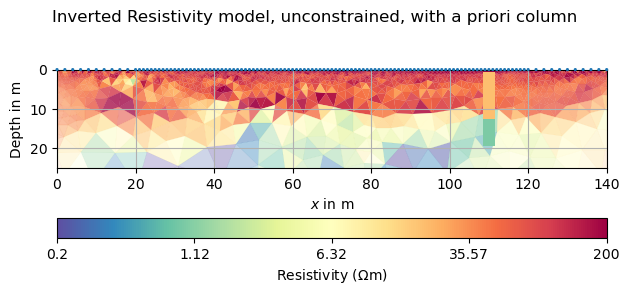

In [25]:
x,z,r = prior['x'], prior['z'], prior['r']

# display earlier unconstrained inversion result with column of layer data
ax, cb = mgr.showResult(**plotkw)
zz = np.abs(z)
iz = np.argsort(z)
dz = np.diff(zz[iz])
thk = np.hstack([dz, dz[-1]])
ztop = -zz[iz[0]] - dz[0]/2
colkw = dict(x=x[0], val=r[iz], thk=thk, width=3, ztopo=ztop)
draw1DColumn(ax, **colkw, **plotkw)
ax.grid(True)
ax.set_ylim(-25,0)
ax.set_xlim(0,140)
fig = plt.gcf()
fig.suptitle("Inverted Resistivity model, unconstrained, with a priori column", y=0.8)
#fig.savefig('Unconstrained_Inversion+apriori_1.png', dpi=200)

We can see this is already a pretty good match, which is perhaps why (as we'll see) the process only makes marginal change to the inversion result in this case.

Let's have a look at a resistivity depth plot through the data at that point.

01/10/24 - 16:12:54 - pyGIMLi - INFO - Found 1 regions.


Text(0.5, 0.98, 'Res-depth profile, unconstrained inversion and a priori data')

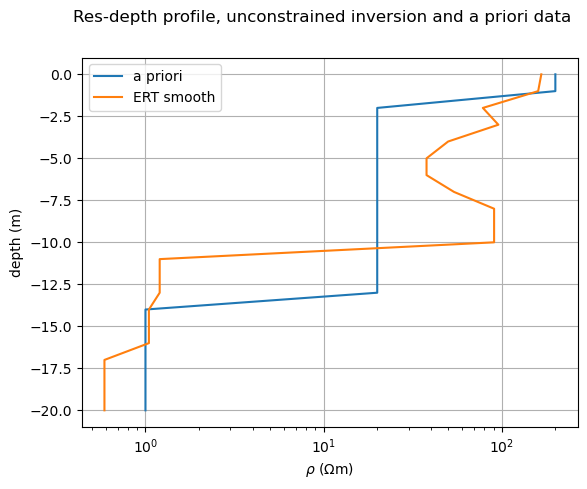

In [26]:
posVec = [pg.Pos(pos) for pos in zip(x, z)]
para = pg.Mesh(mgr.paraDomain)  # make a copy
para.setCellMarkers(pg.IVector(para.cellCount()))
fopDP = PriorModelling(para, posVec)

# Now use that forward operator to extract, store and plot the model values
# compared to the a priori values
fig, ax = plt.subplots()
ax.semilogx(r, z, label="a priori")
resSmooth = fopDP(mgr.model)
ax.semilogx(resSmooth, z, label="ERT smooth")
ax.set_xlabel(r"$\rho$ ($\Omega$m)")
ax.set_ylabel("depth (m)")
ax.grid(True)
ax.legend()
fig = plt.gcf()
fig.suptitle("Res-depth profile, unconstrained inversion and a priori data")
#fig.savefig('Res-depth_ERTSmooth+apriori.png', dpi=200)

"As alternative to smoothness, we can use a geostatistic model. The vertical range can be estimated (*how?*) from the DP data using a variogram analysis, we guess 8m. For the horizontal one, we can only guess a ten times higher value." (from pyGIMLi example)

01/10/24 - 16:18:18 - pyGIMLi - INFO - Use median(data values)=61.0215
01/10/24 - 16:18:18 - pyGIMLi - INFO - Created startmodel from forward operator: 2463, min/max=61.021500/61.021500
01/10/24 - 16:18:18 - pyGIMLi - INFO - Starting inversion.
01/10/24 - 16:18:20 - pyGIMLi - INFO - Creating GeostatisticConstraintsMatrix for region 2 with: I=[40, 4], dip=0, strike=0


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000019BAA6C3C90>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x0000019BAA6C1EE0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000019BD37FBC30>
min/max (data): 6.36/259
min/max (error): 1.5e-04%/2.98%
min/max (start model): 61.02/61.02
--------------------------------------------------------------------------------


01/10/24 - 16:18:25 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 4.7s
01/10/24 - 16:18:25 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\7016434241951062326


inv.iter 0 ... chi² = 323286910.63
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 73377993.04 (dPhi = 77.30%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 13854178.83 (dPhi = 81.12%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 240968.85 (dPhi = 98.26%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 36695.31 (dPhi = 84.76%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 5090.17 (dPhi = 86.04%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 6 ... chi² = 2681.38 (dPhi = 46.98%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 7 ... chi² = 1123.81 (dPhi = 57.31%) lam: 

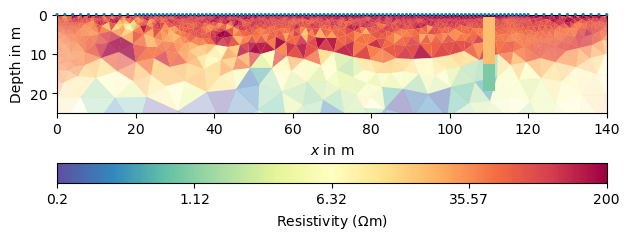

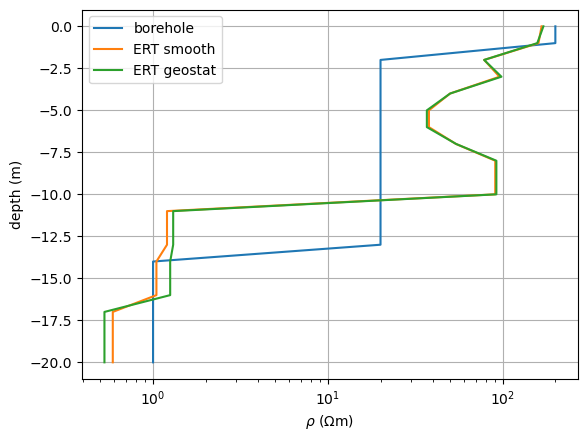

In [27]:
mgr.inv.setRegularization(2, correlationLengths=[40, 4])
mgr.invert()

ax, cb = mgr.showResult(**plotkw)
ax.set_ylim(-25,0)
ax.set_xlim(0,140)
draw1DColumn(ax, **colkw, **plotkw)
resGeo = fopDP(mgr.model)

# Plot compare 'ground truth' with different inversions so far...
fig, ax = plt.subplots()
ax.semilogx(r, z, label="borehole")
ax.semilogx(resSmooth, z, label="ERT smooth")
#ax.semilogx(res2, z, label="ERT aniso")
ax.semilogx(resGeo, z, label="ERT geostat")
ax.set_xlabel(r"$\rho$ ($\Omega$m)")
ax.set_ylabel("depth (m)")
ax.grid()
ax.legend()

So...not much change...